In [147]:
import pandas as pd
import random
from matplotlib import pyplot as plt
from functools import partial
import numpy as np
from itertools import combinations

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import euclidean_distances

random.seed(0)

# Question 1

#### a) Generate Random Data

In [7]:
rows = 1100

X = [random.uniform(-1.5, 1.5) for n in range(rows)]
Y = [random.uniform(-3.5, 1.5) for n in range(rows)]
Z = [random.randint(1, 4) for n in range(rows)]

#### b) Scatterplot of X and Y

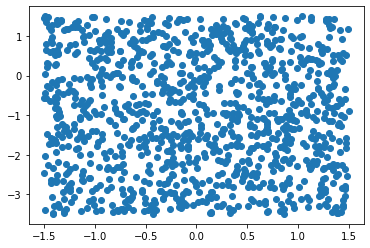

In [8]:
plt.scatter(X, Y)

Because this data is purely random and uniform, it will be difficult to cluster this data in any meaningful way. I would not be surprised to see a very small number of clusters (one or two), as I don't think larger numbers of clusters effectively separate this data.

#### c) K-mean Elbow Method

In [9]:
data = pd.DataFrame(data={'X': X, 'Y': Y, 'Z': Z})

In [16]:
# gb = data.groupby(data.Z)

cluster_variances = dict()
# cluster_centers = gb.agg('mean')

for n_clusters in range(1, 41):
    model = KMeans(n_clusters=n_clusters)
    model.fit(data[['X', 'Y']])
    
    gb = data[['X', 'Y']].groupby(model.labels_)
    cluster_variance = 0  # we will sum all of the cluster variances
    for cluster_id, cluster_data in gb:
        if len(cluster_data) in (0, 1):
            continue  # the variance here is 0
        center = model.cluster_centers_[cluster_id]
        square_sum = np.square(cluster_data - center).sum().sum()
        cluster_variance += square_sum/len(cluster_data)
    cluster_variances[n_clusters] = cluster_variance

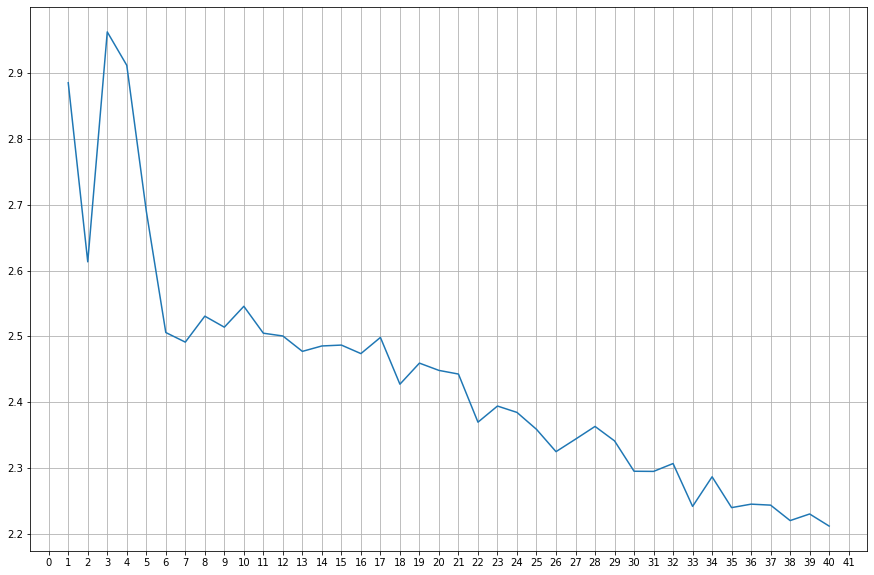

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(cluster_variances.keys(), cluster_variances.values())
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.grid()

It is difficult to use the elbow method on this dataset, but it appears that either k=2 or k=6 are potentially good influection points. We can plot a histogram to see how 6 clusters breaks up the data.

<BarContainer object of 6 artists>

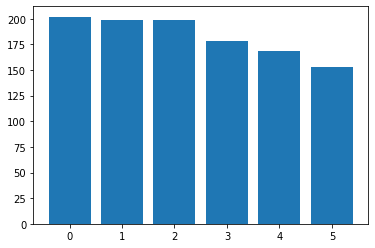

In [19]:
model = KMeans(n_clusters=6)
model.fit(data[['X', 'Y']])

plt.bar(x=list(range(6)), height=pd.Series(model.labels_).value_counts().values)

#### Hierarchical Clustering

In [20]:
# Dendogram plotting function from scikit-learn documention

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

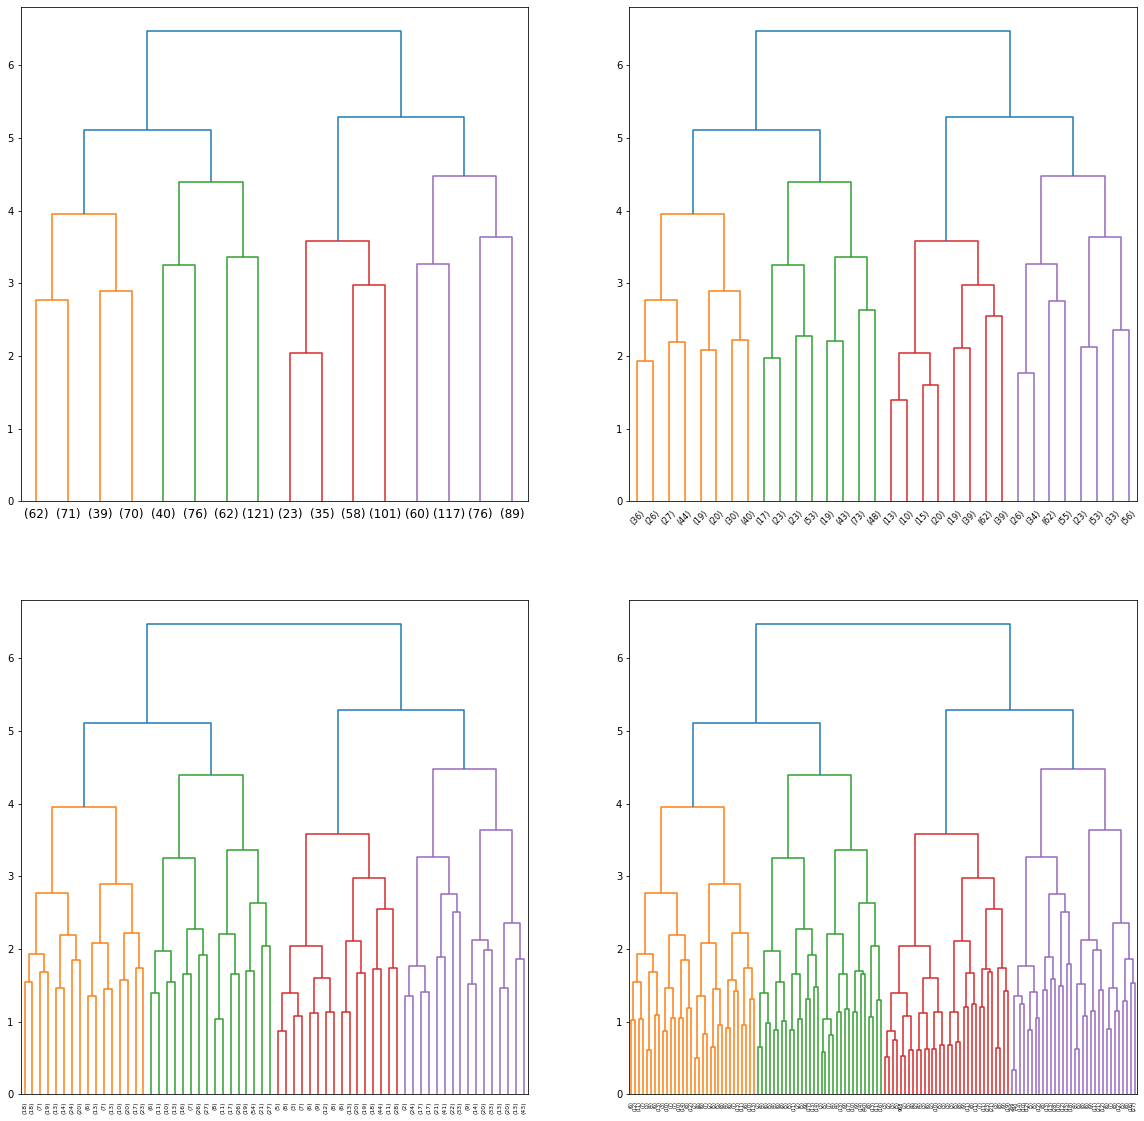

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))

for cut_level, ax  in zip([3, 4, 5, 6], axes.reshape(-1)):
    hier_cluster_complete = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
    hier_cluster_complete.fit(data)
    
    plt.sca(ax)
    plot_dendrogram(hier_cluster_complete, truncate_mode='level', p=cut_level)

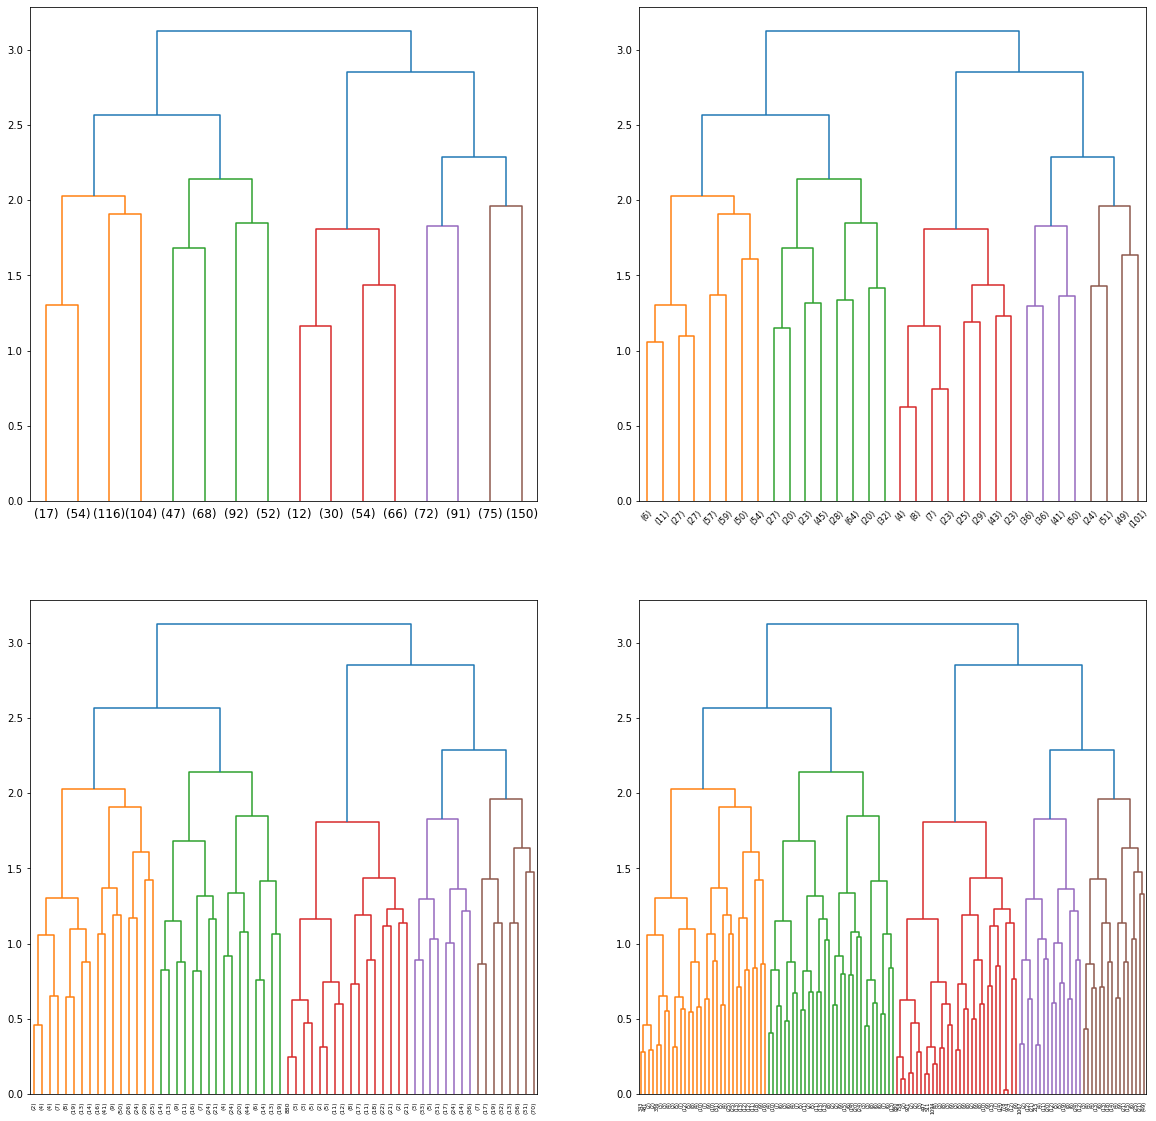

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))

for cut_level, ax  in zip([3, 4, 5, 6], axes.reshape(-1)):
    hier_cluster_complete = AgglomerativeClustering(linkage='average', distance_threshold=0, n_clusters=None)
    hier_cluster_complete.fit(data)
    
    plt.sca(ax)
    plot_dendrogram(hier_cluster_complete, truncate_mode='level', p=cut_level)

Looking at this data, it appears that either 5 or 6 is probably the optimal number of clusters. Additionally, it appears the that average linkage does a cleaner job breaking the data into clusters that are more 'homogenous', less prone to outliers creating clusters that are distorted due to outliers.

# Question 2

In [25]:
q2_data = pd.read_csv('HW3_Q2_1_1.csv', header=None)
q2_data.columns = ['X', 'Y']

#### Repeat the process from Q1 part b and c

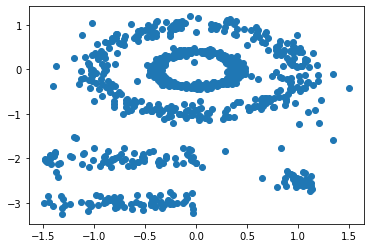

In [26]:
plt.scatter(q2_data.X, q2_data.Y)

In [27]:
cluster_variances = dict()
for n_clusters in range(1, 41):
    model = KMeans(n_clusters=n_clusters)
    model.fit(q2_data)
    
    gb = q2_data.groupby(model.labels_)
    cluster_variance = 0  # we will sum all of the cluster variances
    for cluster_id, cluster_data in gb:
        if len(cluster_data) in (0, 1):
            continue  # the variance here is 0
        center = model.cluster_centers_[cluster_id]
        square_sum = np.square(cluster_data - center).sum().sum()
        cluster_variance += square_sum
    cluster_variances[n_clusters] = cluster_variance

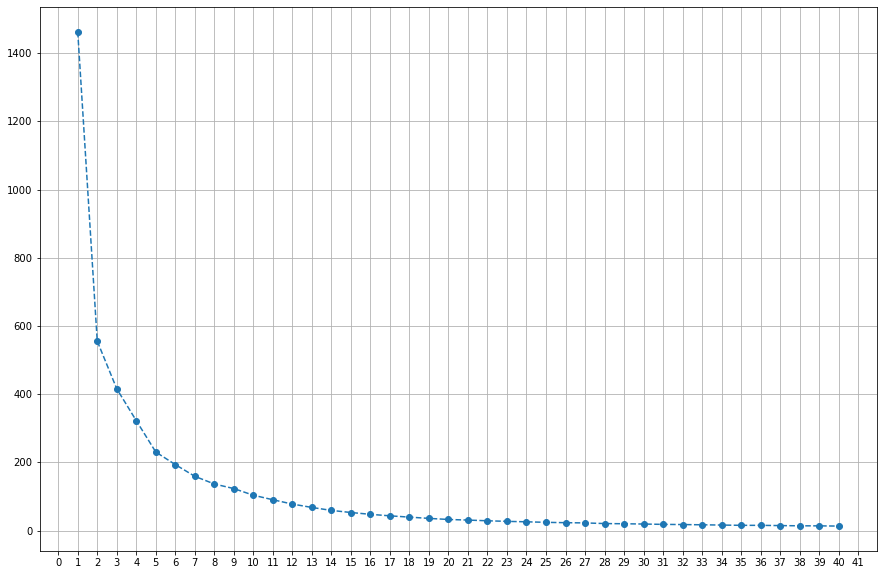

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(cluster_variances.keys(), cluster_variances.values(), 'o--')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.grid()

Looking at this, I think 5 or 6 is the best choice for the number of clusters.

<BarContainer object of 5 artists>

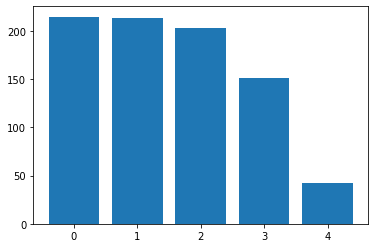

In [27]:
model = KMeans(n_clusters=5)
model.fit(q2_data)

plt.bar(x=list(range(5)), height=pd.Series(model.labels_).value_counts().values)

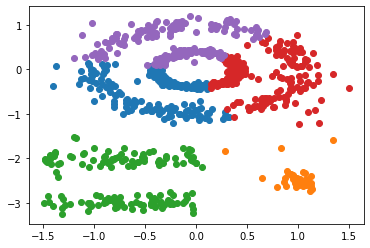

In [28]:
gb = q2_data.groupby(model.labels_)
for group, data in gb:
    plt.scatter(data.X, data.Y)

While this somewhat looks good, it certainly is *not* capturing the stucture of the underlying data.

#### Q2 part c

In [29]:
q2_c_data = pd.read_csv("HW3_Q2_1.csv", header=None)
q2_c_data.columns = ['X', 'Y', 'Z']

print(f"Professor num clusters: {q2_c_data.Z.nunique()}")

Professor num clusters: 6


The provided dataset has six clusters, compared to my five. Visually, this can be seen below.

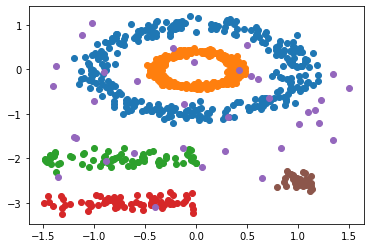

In [30]:
gb = q2_c_data.groupby(q2_c_data.Z)
for group, data in gb:
    plt.scatter(data.X, data.Y)

Now, lets calculate each class' centroid.

In [31]:
gb.agg('mean')

,X,Y
Z,,
1,0.004117,-0.032522
2,0.000931,-0.000039
3,-0.745821,-2.012618
4,-0.680295,-2.986390
5,0.035084,-0.879751
6,1.004459,-2.503944


Lets try running Kmeans again, now that we know the correct cluster number is 6. There is not much we can due in terms of hyperparamter tuning, the only hyper parameters we have are tolerance and the initialization method.

In [32]:
for k in range(2, 10):
    model = KMeans(n_clusters=k, max_iter=1000).fit(q2_data)
    silhouette_avg = silhouette_score(q2_data, model.labels_)
    print(f'Clusters k={k} silhouette score: {silhouette_avg}')

Clusters k=2 silhouette score: 0.599365875192714
Clusters k=3 silhouette score: 0.37956405134206184
Clusters k=4 silhouette score: 0.38716823833923814
Clusters k=5 silhouette score: 0.41534027736357265
Clusters k=6 silhouette score: 0.4220521223625926
Clusters k=7 silhouette score: 0.39847092286384506
Clusters k=8 silhouette score: 0.40231328542257166
Clusters k=9 silhouette score: 0.41819276003647343


Using this result, we can estimate there are either 3 clusters or potentially 8. Let's try plotting 8 clusters to see how it compares to the true classes.

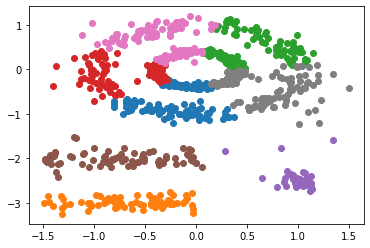

In [33]:
model = KMeans(n_clusters=8, max_iter=1000).fit(q2_data)
gb = q2_data.groupby(model.labels_)
for group, data in gb:
    plt.scatter(data.X, data.Y)

We can tabulate the new centroids as well:

In [34]:
gb.agg('mean')

,X,Y
0,-0.185905,-0.660513
1,-0.676552,-2.987702
2,0.480798,0.400174
3,-0.678920,-0.086977
4,0.982544,-2.446945
5,-0.746715,-2.003212
6,-0.303202,0.582550
7,0.612724,-0.369881


This has definitely improved on the first attempt at clustering, but k-means still struggles to model the inner structure properly. This is because the centroids for these two classes lie virtually on top of each other.

# Question 3

In [2]:
q3_data = pd.read_csv('HW3_Q4_01_1.csv', header=None)
q3_data.columns = q3_data.columns.astype(str)

In [3]:
def kmeans_alt(data, n_clusters=3, max_iter=300):
    centers = random.sample(list(data.to_numpy()), 1)
    while len(centers) < n_clusters:
        dists = euclidean_distances(data.to_numpy(), centers).min(axis=1)
        perc = dists / dists.sum()
        index = np.random.choice(list(range(len(data))), p=perc)
        centers.append(list(data.to_numpy())[index])

    dists = euclidean_distances(data.to_numpy(), centers)
    cluster = dists.argmin(axis=1)
    for i in range(max_iter):
        new_centers = list(data.groupby(cluster).agg('mean').to_numpy())
        try:
            if set(tuple(arr) for arr in new_centers) == set(tuple(arr) for arr in centers):
#                 print(f'converged on iter: {i}')
                break  # converged!
        except:
            return new_centers, centers
        centers = new_centers
        dists = euclidean_distances(data.to_numpy(), centers)
        cluster = dists.argmin(axis=1)
    return centers, cluster

In [31]:
cluster_variances = dict()

for n_clusters in range(1, 40):
    cluster_centers, cluster_labels = kmeans_alt(q3_data, n_clusters=n_clusters)
    gb = q3_data.groupby(cluster_labels)
    cluster_variance = 0  # we will sum all of the cluster variances
    for cluster_id, cluster_data in gb:
        center = cluster_centers[cluster_id]
        square_sum = np.square(cluster_data - center).sum().sum()
        cluster_variance += square_sum
    cluster_variances[n_clusters] = cluster_variance

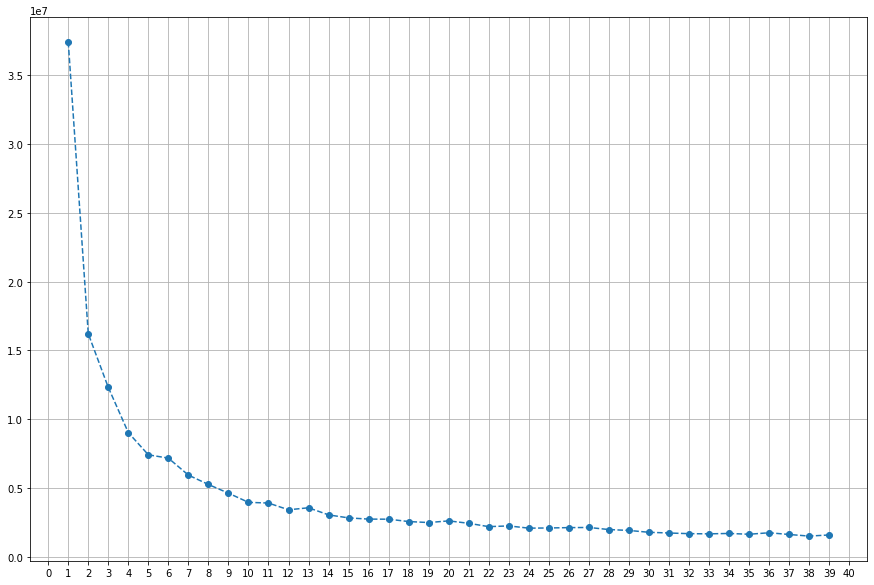

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(cluster_variances.keys(), cluster_variances.values(), 'o--')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.grid()

Here, I think 5 clusters is the best. For visualizaiton, I plotted x/y of every variable combination, and the clusters.

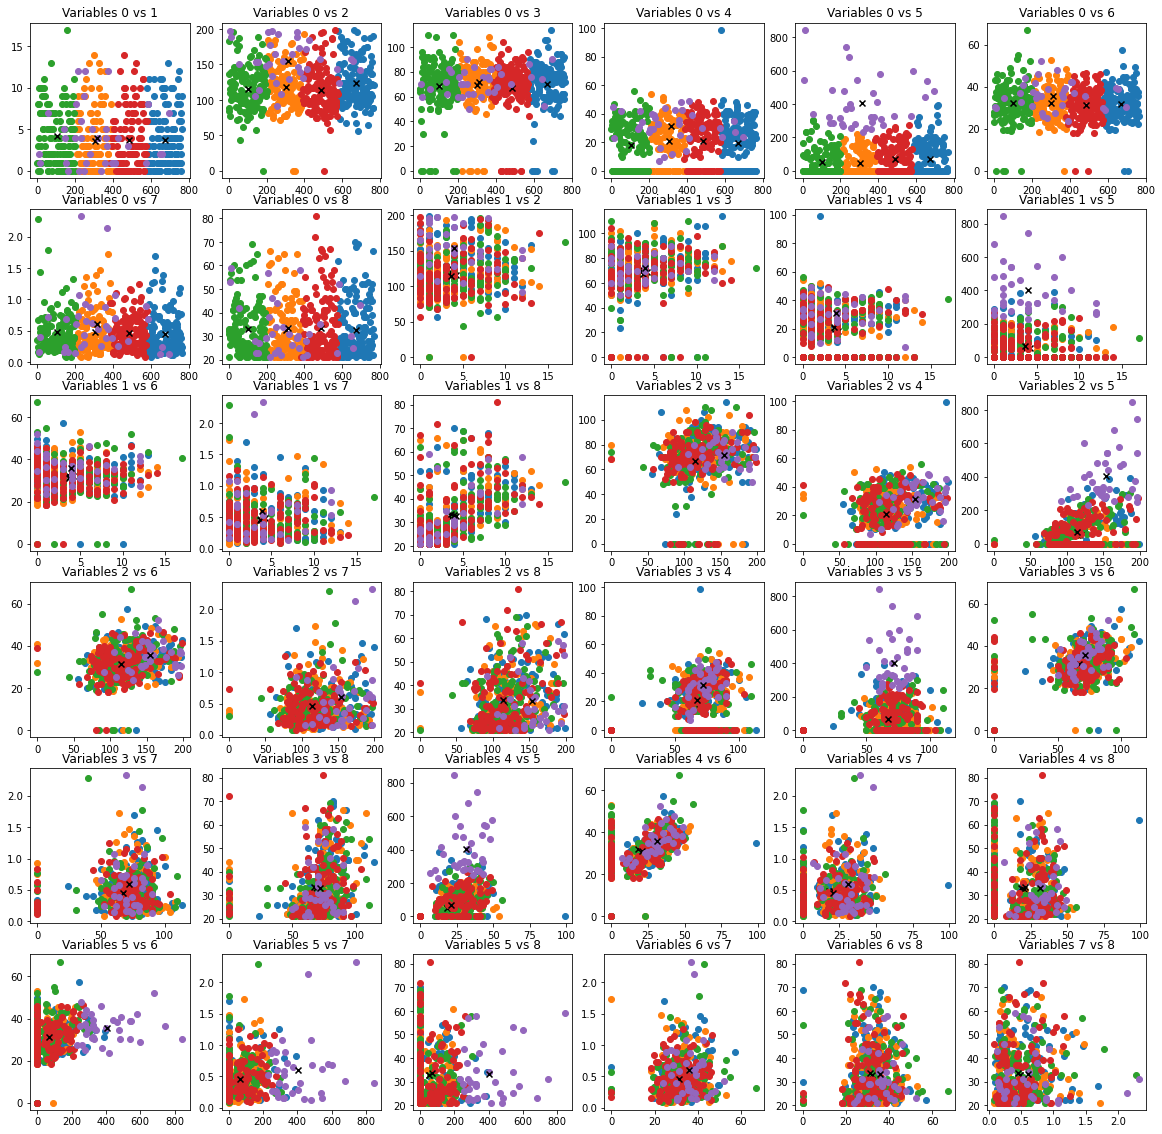

In [39]:
centers, cluster_labels = kmeans_alt(q3_data, n_clusters=5)

fig, axes = plt.subplots(6, 6, figsize=(20,20))

gb = q3_data.groupby(cluster_labels)
for ax, (x, y) in zip(axes.reshape(-1), combinations(list(range(9)), 2)):
    ax = plt.sca(ax)
    for group, data in gb:
        plt.scatter(data[str(x)], data[str(y)])
        plt.scatter(centers[group][x], centers[group][y], c='k', marker='x')
        
        plt.title(f'Variables {x} vs {y}')

#### Logistic Regression

In [130]:
q3_clustered = q3_data.copy()
centers, labels = kmeans_alt(q3_clustered, n_clusters=5)
q3_clustered['cluster'] = labels

X = q3_clustered[list(map(str, range(9)))]
y = labels

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [131]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

predict = lr.predict(scaler.transform(X_test))

acc = accuracy_score(y_test, predict)

print(f"Custom Cluster Logisitic Regression Accuracy: {acc}")

Custom Cluster Logisitic Regression Accuracy: 0.9827586206896551


#### Comparing my function to sklearn...

In [132]:
sklearn_data = q3_data.copy()

model = KMeans(n_clusters=5)
model.fit(sklearn_data)

sklearn_data['cluster'] = model.labels_

X = sklearn_data[list(map(str, range(9)))]
y = sklearn_data['cluster']

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lr2 = LogisticRegression()
lr2.fit(X_train_scaled, y_train)

predict = lr2.predict(scaler.transform(X_test))

acc = accuracy_score(y_test, predict)

print(f"Sklearn Cluster Logisitic Regression Accuracy: {acc}")

Sklearn Cluster Logisitic Regression Accuracy: 0.9482758620689655


I ran this a few times, my cluster sometimes wins in performance!

# Q4

In [139]:
new_train = pd.read_csv('HW3_Q4_1.csv', header=None)
new_test = pd.read_csv('HW3_Q4_2.csv')

new_train.columns = new_train.columns.astype(str)
new_test.columns = list(map(str, range(10)))

In [140]:
new_test['9'].unique()

array([0, 1], dtype=int64)

In [141]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(new_train[list(map(str, range(9)))])
X_test_scaled = scaler.transform(new_test[list(map(str, range(9)))])

y_train = new_train['9']
y_test = new_test['9']

This data only contains two classes, which is very unlike what I trained the model with (5). I will retrain the model from step three with the old data, but two clusters, so it matches this data.

In [142]:
q3_clustered = q3_data.copy()
centers, labels = kmeans_alt(q3_clustered, n_clusters=2)
q3_clustered['cluster'] = labels

old_X = q3_clustered[list(map(str, range(9)))]
old_y = labels

old_X_train, _, old_y_train, _ =  train_test_split(X, y, test_size=0.1)

scaler = StandardScaler()
old_X_train_scaled = scaler.fit_transform(X_train)

old_model = LogisticRegression()
old_model.fit(old_X_train_scaled, old_y_train)

LogisticRegression()

In [146]:
old_pred = old_model.predict(X_test_scaled)
acc = accuracy_score(y_test, old_pred)

print(f'Old Model Accuracy: {acc}')

Old Model Accuracy: 0.3958333333333333


This "old" model does quite poor.

#### New model

In [120]:
new_model = LogisticRegression()
new_model.fit(X_train_scaled, y_train)

new_pred = new_model.predict(X_test_scaled)
acc = accuracy_score(y_test, new_pred)

print(f'New Model Accuracy: {acc}')

New Model Accuracy: 0.7760416666666666


Of course, we see a huge increase in accuracy (we trained using the appropriate number of classes).

#### Random Forest

In [129]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)

rf_pred = rfc.predict(X_test_scaled)

acc = accuracy_score(y_test, rf_pred)

print(f'Random Forest Accuracy: {acc}')

Random Forest Accuracy: 0.7447916666666666


#### Gradient Boost

In [149]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled, y_train)

gb_pred = gbc.predict(X_test_scaled)

acc = accuracy_score(y_test, gb_pred)

print(f'Random Forest Accuracy: {acc}')

Random Forest Accuracy: 0.7760416666666666


# Summary

The table below shows all of my accuracy results:

In [150]:
results = pd.DataFrame({'Old LR Model (trained with 2 clusters)': [0.396],
                        'New LR Model': [0.776],
                        'Random Forest': [0.745],
                        'Gradient Boost': [0.776]})
results

,Old LR Model (trained with 2 clusters),New LR Model,Random Forest,Gradient Boost
0,0.396,0.776,0.745,0.776


Overall, the new Logistic Regression and the Gradient Boost models performed the best (and equivalently). The Random Forest model performed similarly but slightly worse, and the old Logistic Regression model performed terribly. Either model works fine for this use-case, and both trained very quickly.